In [2]:
from scipy.special import gamma
from scipy import integrate as intg
from scipy import optimize
import scipy.stats as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
def c(alpha,r,j,n):
    """Function that computes the coefficient cj"""
    cj = (r**(1-alpha)-1) * r**((1-alpha)*(j-1-n/2)) / (gamma(alpha)*gamma(2-alpha))
    return cj

def x(alpha,r,j,n):
    """Function that computes the coefficient xj"""
    xj = (1-alpha)*(r**(2-alpha)-1)*(r**(j-1-n/2)) / ((2-alpha)*(r**(1-alpha)-1))
    return xj

def g0(t,V0,lamb,theta,n,rn,alpha):
    """Function that returns the value of g0 at time t"""
    g_0 = V0     # Initialise g0
    for j in range(n):
        cj = c(alpha,rn,j+1,n)      # Compute the next cj
        xj = x(alpha,rn,j+1,n)      # Compute the next xj
        g_0 += lamb*theta*cj*(1-np.exp(-xj*t))/xj     # Add the new term to g_0   
    return g_0

def F(u,v,rho,nu,lamb):
     """Function that returns the value of F(u,v)"""
    F_u_v = (u**2-u)/2 + (rho*u*nu-lamb)*v + nu**2*v**2/2
     return  F_u_v

## Question 2

In [45]:
def Ch_Lifted_Heston(u,S0,T,rho,lamb,theta,nu,V0,n,rn,alpha,M):
    """Function that approximates the characteristic function in the Lifted Heston model"""
    i = complex(0,1)     # The complex number i
    h = T/M     # Time discretization step
    Psi = np.zeros(n)     # Initialise the Psi functions at 0
    cj = np.array([c(alpha,rn,j+1,n) for j in range(n)])     # Compute the cj coefficients
    xj = np.array([x(alpha,rn,j+1,n) for j in range(n)])     # Compute the xj coefficients
    SumcjPsi = np.sum(cj*Psi)     # Initialise the sum of Psi function at 0
    Intg = F(i*u,SumcjPsi,rho,nu,lamb)*g0(T,V0,lamb,theta,n,rn,alpha)*h      # Initialise the integral's value
    for k in range(M):
        Psi = 1/(1+xj*h)*(Psi + F(i*u,SumcjPsi,rho,nu,lamb)*h)      # Update of Psi
        SumcjPsi = np.sum(cj*Psi)     # Update of the sum of Psi
        Intg += F(i*u,SumcjPsi,rho,nu,lamb)*g0(T-(k+1)*h,V0,lamb,theta,n,rn,alpha)*h     # Add the new term to Intg
    Phiu = np.exp(i*u*np.log(S0) + Intg)     # The final value of the fourrier transform
    return Phiu

## Question 3

In [46]:
def Call_Price_Lifted_Heston(S0,K,T,rho,lamb,theta,nu,V0,n,rn,alpha,M,alpha2,L):
    """Function that approximates the call option price in the Lifted Heston model"""
    i = complex(0,1)     # The complex number i
    Real_Ch_Lifted_Heston = lambda u: (Ch_Lifted_Heston(u-(alpha2+1)*i,S0,T,rho,lamb,theta,nu,V0,n,rn,alpha,M)*np.exp(-i*np.log(K)*u)/((alpha2+i*u)*(alpha2+1+i*u))).real     # The function within the integral
    C0 = np.exp(-alpha2*np.log(K))/(np.pi) * intg.quad(Real_Ch_Lifted_Heston,0,L)[0]     # The call option price
    return C0

## Question 4

In [47]:
def BlackScholes(S0,K,T,r,vol):
    """Function which calculates the B&S call's price"""
    d1 = (np.log(S0/K) + (r+0.5*vol**2)*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    Phid1 = sp.norm.cdf(d1)
    Phid2 = sp.norm.cdf(d2)
    call = S0*Phid1 - K*np.exp(-r*T)*Phid2
    return call

def Vega(S0,K,T,r,vol):
    """Function which calculates the call's vega"""
    d1 = (np.log(S0/K) + (r+0.5*vol**2)*T)/(vol*np.sqrt(T))
    return S0*np.sqrt(T)*np.exp(-0.5*d1**2)/np.sqrt(2*np.pi)

In [48]:
#Parameters 

S0 = 1
rho = -0.7
lamb = 0.3
theta = 0.02
nu = 0.3
V0 = 0.02
alpha = 0.6
alpha2 = 1
M = 100
Factors = [5,10,20,50]

In [49]:
def PlotSmile(S0,Strikes,T,rho,lamb,theta,nu,V0,Factors,alpha,M,alpha2,L):
    
    """ A function which allows to draw the smile of implicit voaltility on a 
        range of strike given for different values of factors n"""
    
    for n in Factors:
        rn = 1+10*n**(-0.9)      # Compute rn depending on n 
        SmilePoints = [0]*len(Strikes)      # Initialize the implicit volatility list corresponding to n
        for ind,strike in enumerate(Strikes):
            HestonPrice = Call_Price_Lifted_Heston(S0,strike,T,rho,lamb,theta,nu,V0,n,rn,alpha,M,alpha2,L)     # Compute the lifted Heston price for K=strike
            DiffPrice = lambda vol: BlackScholes(S0,strike,T,0,vol) - HestonPrice      # Define the price difference function between B&S and Heston
            DiffPricePrime = lambda vol: Vega(S0,strike,T,0,vol)      # Define the derivative function of DiffPrice with respect to volatility
            impvol = optimize.newton(DiffPrice,0.35,DiffPricePrime)      # Compute the implied volatility using Newton Raphson algorithm
            SmilePoints[ind] = impvol      # Complete the list of implied volatilities
        plt.plot(Strikes,SmilePoints,label="n = " + str(n))      # Plot the implied volatility smile 
        plt.legend(loc = "best")    # Add the legend
        plt.xlabel("Strikes")    
        plt.ylabel("Implied Volatility")
        plt.grid("True")
        plt.title("Lifted Heston's implied volatility for T = " + str(T) + "and L = " + str(L))

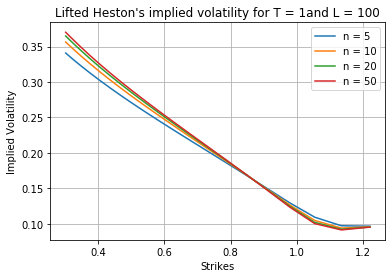

In [50]:
# Application for T=1 and L=100

LogStrikes = np.linspace(-1.2,0.2,20)
Strikes = np.exp(LogStrikes)
L = 100
T = 1
PlotSmile(S0,Strikes,T,rho,lamb,theta,nu,V0,Factors,alpha,M,alpha2,L)

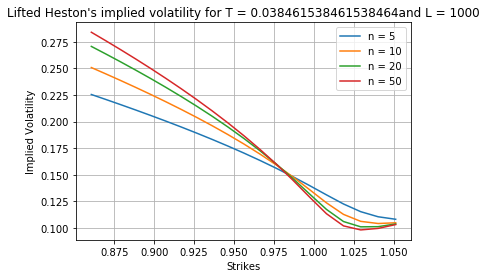

In [51]:
# Application for T=1/26 and L=1000

LogStrikes = np.linspace(-0.15,0.05,20)
Strikes = np.exp(LogStrikes)
L = 1000
T = 1/26
PlotSmile(S0,Strikes,T,rho,lamb,theta,nu,V0,Factors,alpha,M,alpha2,L)